## Import the Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Section 2.1.1 Image Loading and Exploration

In [2]:
image_path = "cloverleaf_interchange.png" 

In [3]:
def load_cloverleaf_image(image_path):
    """
    Reads the cloverleaf image, displays it, and provides basic information.
    Parameters:
        image_path (str): Path to the input image.
    Returns:
        np.ndarray: Loaded image.
    """
    # Load the image in color mode
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    if image is None:
        raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded.")
    
    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Provide basic information about the image
    print(f"Image Dimensions: {image.shape}")
    for i, color in enumerate(['Blue', 'Green', 'Red']):
        print(f"{color} Channel - Pixel Value Range: {image[:,:,i].min()} to {image[:,:,i].max()}")
        print(f"{color} Channel - Mean Pixel Value: {image[:,:,i].mean():.2f}")
        print(f"{color} Channel - Standard Deviation of Pixel Values: {image[:,:,i].std():.2f}")
    
    return image

In [4]:
def calculate_histogram(image):
    """
    Computes the histogram of an image manually.
    Parameters:
        image (np.ndarray): Input grayscale image.
    Returns:
        np.ndarray: Histogram of pixel intensities.
    """
    # Initialize an array to store pixel intensity counts
    histogram = np.zeros(256, dtype=int)
    
    # Count the occurrences of each pixel intensity
    for value in image.flatten():
        histogram[value] += 1
    
    return histogram

In [6]:
# Load a color image
image = cv2.imread(image_path)

# Split the image into its B, G, R channels
B, G, R = cv2.split(image)

# Now B, G, and R are separate 2D arrays
print(B.shape)  
print(G.shape)  
print(R.shape)  

(1207, 1207)
(1207, 1207)
(1207, 1207)


In [7]:
def plot_histograms(image):
    """
    Plots separate histograms for each channel of an RGB image calculated manually and using OpenCV.
    Parameters:
        image (np.ndarray): Input RGB image.
    """
    # Check if the image has 3 channels
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")

    channels = ['Blue', 'Green', 'Red']
    for i, channel in enumerate(cv2.split(image)):
        # Calculate histograms
        manual_histogram = calculate_histogram(channel)
        opencv_histogram = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()

        # parameters: image, channels, mask, histSize, ranges ([0] channel means we need to calculate for first channel for gray scale image it would be always 0)
        
        # Plot manual histogram
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(manual_histogram, color='blue')
        plt.title(f"Manual Histogram - {channels[i]} Channel")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)
        
        # Plot OpenCV histogram
        plt.subplot(1, 2, 2)
        plt.plot(opencv_histogram, color='red', linestyle='dashed')
        plt.title(f"OpenCV Histogram - {channels[i]} Channel")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

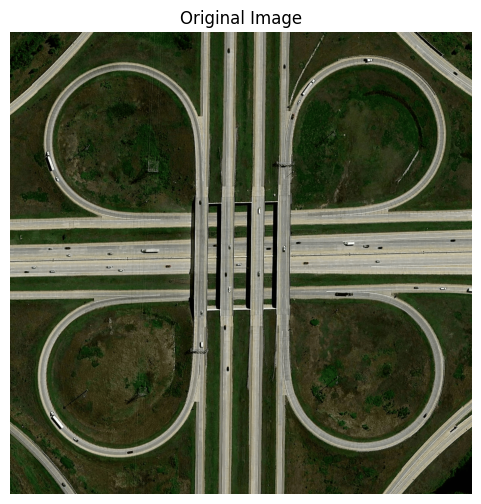

Image Dimensions: (1207, 1207, 3)
Blue Channel - Pixel Value Range: 0 to 249
Blue Channel - Mean Pixel Value: 53.78
Blue Channel - Standard Deviation of Pixel Values: 56.64
Green Channel - Pixel Value Range: 1 to 253
Green Channel - Mean Pixel Value: 77.64
Green Channel - Standard Deviation of Pixel Values: 52.81
Red Channel - Pixel Value Range: 1 to 250
Red Channel - Mean Pixel Value: 72.30
Red Channel - Standard Deviation of Pixel Values: 57.87


In [6]:
image = load_cloverleaf_image(image_path)


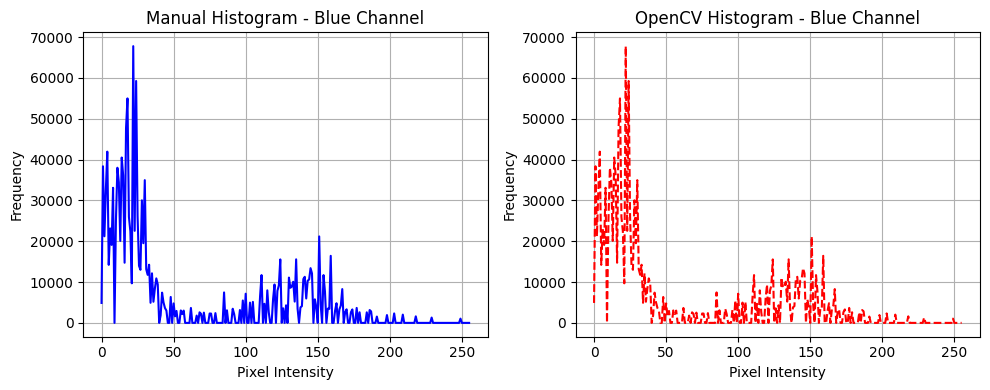

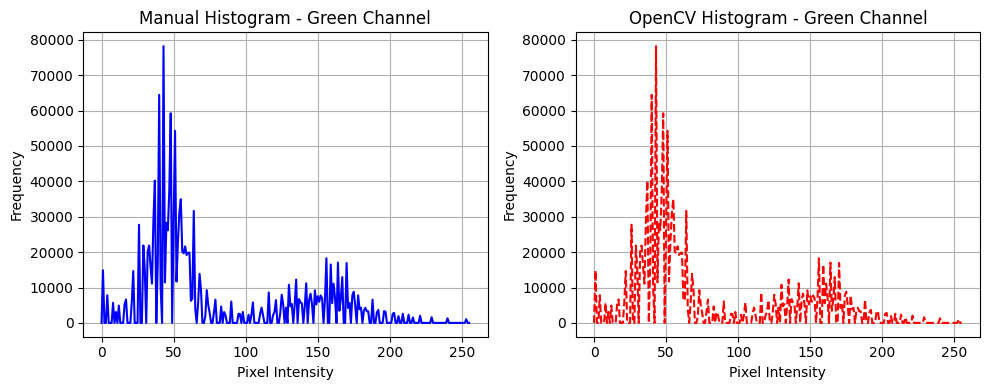

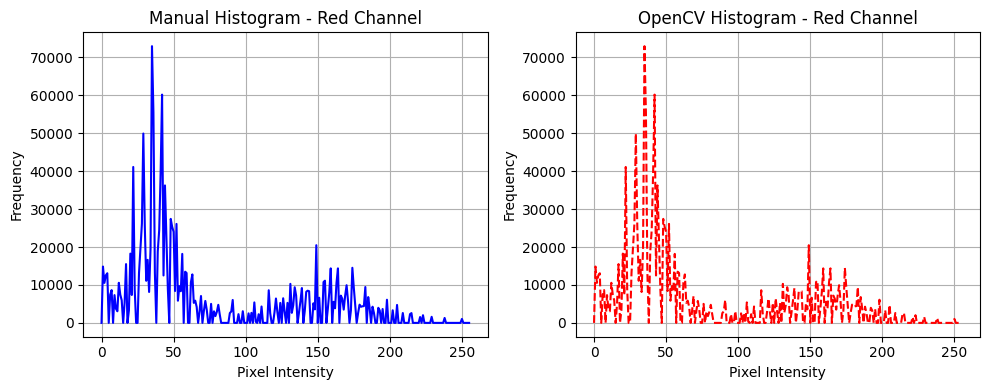

In [8]:
plot_histograms(image)


The histogram implemented by openCv is similar to one implemented manually.

In [9]:
def preprocess_image(image_path):
    """
    Preprocess the image to enhance it for the detection of clover leaves.
    Applies color conversion, noise reduction, and edge detection.
    Displays the preprocessed image after each major step.
    Args:
        image_path (str): Path to the input image.
    
    Returns:
        edges (numpy.ndarray): Edge-detected image.
        processed_image (numpy.ndarray): Preprocessed image for visualization.
    """
    # Load the image
    image = cv2.imread(image_path)
    
    # 1. Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Grayscale Image")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    # 2. Noise Reduction (Gaussian Blur)
    blurred = cv2.GaussianBlur(gray, (5, 5), 2)
    plt.subplot(1, 3, 2)
    plt.title("Blurred Image")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')

    # 3. Edge Detection (Canny)
    edges = cv2.Canny(blurred, 50, 150)
    plt.subplot(1, 3, 3)
    plt.title("Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.show()
    return edges, image

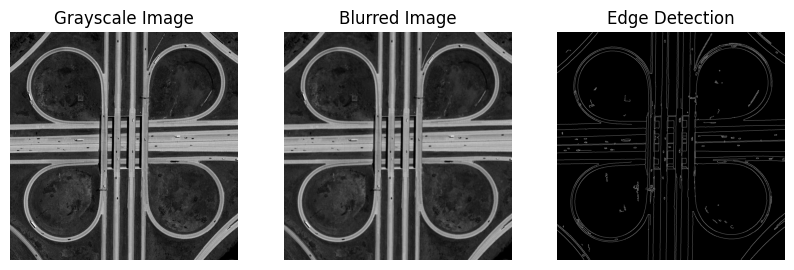

In [10]:
edges,original_image=preprocess_image(image_path)

In [11]:
def detect_cloverleaves(edges, original_image):
    """
    Detect circular structures (clover leaves) in the edge-detected image.
    Visualize the detected circles on the original image.

    Args:
        edges (numpy.ndarray): Edge-detected image.
        original_image (numpy.ndarray): Original input image.
    
    Returns:
        output_image (numpy.ndarray): Image with detected circles marked.
        circles (list): List of detected circles with their centers and radii.
    """
    # Copy original image for visualization
    output = original_image.copy()

    # Apply Hough Circle Transform
    # The function returns a list of detected circles. Each circle is represented as a 3-element vector ((x_{center}, y_{center}, radius)).

    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,      # Minimum distance between circle centers
        param1=50,        # Gradient value for edge detection
        param2=30,        # Accumulator threshold for circle detection, lower value for more circles (false positives)
        minRadius=205,     # Minimum radius of circles
        maxRadius=213     # Maximum radius of circles
    )

    # Draw the detected circles
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle with radius2 and thickness 3
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.title("Detected Clover Leaves")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return output, circles


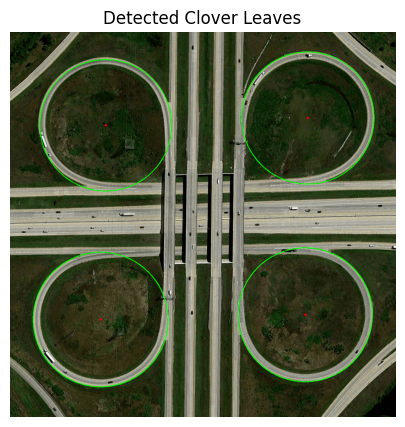

In [12]:
output_image, circles = detect_cloverleaves(edges, original_image)

## Analysis and Justification for Cloverleaf Detection

### 1. Impact of Preprocessing Techniques

Preprocessing plays a crucial role in enhancing the image for cloverleaf detection:

- **Grayscale Conversion**: Simplifies the image by removing unnecessary color information, making it easier to focus on structural features.

- **Gaussian Blur**: Reduces noise in the image, which helps avoid the detection of false circles caused by random variations in pixel intensities.Initially, many unnecessary circles were being detected due to noise. Applying Gaussian blur significantly reduced these false detections.

- **Edge Detection (Canny)**: Highlights the boundaries of shapes, making it easier to detect circular structures in the image.


### 2. Method and Parameter Choices
- **Method**: The Hough Circle Transform was used for circle detection, as it is robust for detecting circular shapes in noisy or cluttered images.
- **Parameter Choices**:
  - `dp=1.2`: Maintains a good balance between resolution and computational cost for the accumulator matrix.
  - `minDist=100`: Ensures that circles are not detected too close to each other, preventing overlap.
  - `param1=50`: Threshold for edge detection, chosen to balance between under-detection and over-detection of edges.
  - `param2=30`: Determines the sensitivity for circle detection; smaller values reduce false positives.
  - `minRadius=205` and `maxRadius=213`: Manually adjusted to include only the cloverleaf shapes while excluding smaller or larger circular structures. Adjusting the `minRadius` and `maxRadius` values ensured that only cloverleaf shapes were detected.

### 3. Challenges and Potential Failures
- **Challenges**:
  - Overlapping circles or distorted shapes: Some cloverleaf shapes were overlapping and they deviate from perfect circularity, causing detection challenges.

  - False detections: The algorithm initially detected many other circular features due to noise or artifacts, which were filtered by fine-tuning the preprocessing and detection parameters.

- **Potential Failures**:
  - The algorithm might fail in cases where **manual radius estimation** is not feasible (e.g., dynamic detection in varying images). Without proper radius constraints, it may detect unwanted circular features.

  - Uneven lighting or shadows in the image might affect the performance of edge detection, leading to missed or inaccurate detections.
  
  - Algorithm would have to tuned when detecting circles of variable radius since in that case the radius would have to be estimated dynamically, different for each circle.

In [21]:
def calculate_radii_and_visualize(circles, original_image):
    """
    Calculate the radii of detected circles and visualize them with their centers and radii labeled.

    Args:
        circles (list): List of detected circles with their centers and radii.
        original_image (numpy.ndarray): Original input image.

    Returns:
        radii (list): List of radii (in pixels) for each detected circle.
    """
    # Copy the original image for visualization
    output = original_image.copy()
    radii = []

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for idx, circle in enumerate(circles[0, :]):
            center = (circle[0], circle[1])  # Circle center (x, y)
            radius = circle[2]              # Circle radius
            
            # Add radius to the list
            radii.append(radius)

            # Draw the circle and its center
            cv2.circle(output, center, radius, (0, 255, 0), 2)  # Circle
            cv2.circle(output, center, 2, (0, 0, 255), 3)       # Center

            # Label the radius on the image
            label = f"R{idx + 1}={radius} px"
            label_position = (center[0] - 60, center[1] - 20)  # Adjust label position
            font_scale = 0.8 
            font_thickness = 2 
            text_color = (255, 255, 0) 
            cv2.putText(output, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 
                        font_scale, text_color, font_thickness, cv2.LINE_AA)

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.title("Detected Circles with Labeled Radii")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Print the radii
    for idx, radius in enumerate(radii):
        print(f"Circle {idx + 1}: Radius = {radius:.2f} pixels")

    return radii

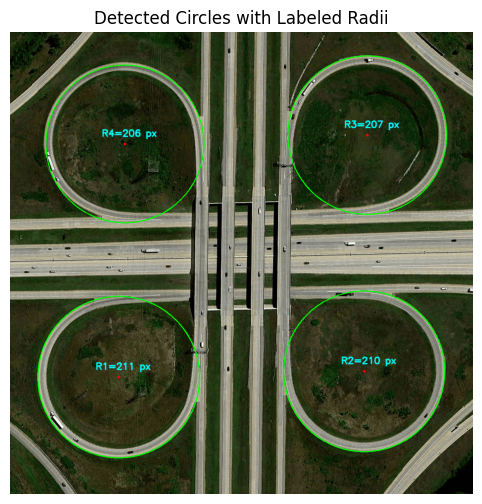

Circle 1: Radius = 211.00 pixels
Circle 2: Radius = 210.00 pixels
Circle 3: Radius = 207.00 pixels
Circle 4: Radius = 206.00 pixels


In [22]:
radii = calculate_radii_and_visualize(circles, original_image)


## Section 2.2.3: Explanation of Radius Calculation

### 1. Chosen Detection Method
- **Hough Circle Transform**: Detects circular shapes and provides their center coordinates `(x, y)` and radius `(r)`.

### 2. Assumptions
- Cloverleaves are near-circular, allowing reliance on radius estimation.  
- Radius is consistent across the detected circle's edge.

### 3. Sources of Error
- Distorted or incomplete cloverleaves may result in inaccurate radius estimation.  
- Noise or incorrect preprocessing can lead to false detections or incorrect radii.

In [25]:
def calculate_area_from_radii(radii):
    """
    Calculate the approximate area of each detected cloverleaf based on its radius.

    Args:
        radii (list): List of radii (in pixels) for the detected circles.

    Returns:
        areas (list): List of areas (in square pixels) for each detected circle.
    """
    areas = []
    for idx, radius in enumerate(radii):
        # Calculate the area using A = πr^2
        area = np.pi * (radius ** 2)
        areas.append(area)

        # Print the area
        print(f"Circle {idx + 1}: Approximate Area = {area:.2f} square pixels")

    return areas

In [26]:

areas = calculate_area_from_radii(radii)

Circle 1: Approximate Area = 139866.85 square pixels
Circle 2: Approximate Area = 138544.24 square pixels
Circle 3: Approximate Area = 134614.10 square pixels
Circle 4: Approximate Area = 133316.63 square pixels


In [29]:
def calculate_area_from_pixels(circles, image_shape):
    """
    Calculate the approximate area of each detected cloverleaf by counting pixels within the detected regions.

    Args:
        circles (list): List of detected circles with their centers and radii.
        image_shape (tuple): Shape of the input image (height, width).

    Returns:
        areas (list): List of areas (in square pixels) for each detected circle.
    """
    if circles is None:
        print("No circles detected.")
        return []

    areas = []
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    circles = np.uint16(np.around(circles))
    for idx, circle in enumerate(circles[0, :]):
        center = (circle[0], circle[1])
        radius = circle[2]

        # Create a binary mask for the current circle
        cv2.circle(mask, center, radius, 255, -1)  # -1 to fill the circle

        # Count non-zero pixels in the mask
        area = np.sum(mask == 255)
        areas.append(area)

        # Reset the mask for the next circle
        mask.fill(0)

        # Print the area
        print(f"Circle {idx + 1}: Pixel Count Area = {area:.2f} square pixels")



In [30]:
calculate_area_from_pixels( circles, original_image.shape)

Circle 1: Pixel Count Area = 139809.00 square pixels
Circle 2: Pixel Count Area = 138505.00 square pixels
Circle 3: Pixel Count Area = 134565.00 square pixels
Circle 4: Pixel Count Area = 133301.00 square pixels


## Section 2.2.4: Comparison of Area Calculation Methods

### 1. Using the Radius (`A = πr²`)
- **Advantages**:  
  - Fast and computationally inexpensive.  
  - Accurate for near-perfect circles.  
- **Disadvantages**:  
  - Inaccurate for irregular or distorted shapes.

### 2. Pixel Counting (Alternate Method)
- **Description**: Segments the circle region and counts the number of pixels.  
- **Advantages**:  
  - More accurate for irregular shapes.  
- **Disadvantages**:  
  - Computationally expensive.  
  - Requires precise segmentation.